In [5]:
# Import libraries
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Create the Pendulum environment (continuous control) with updated render mode and step API
env = gym.make("Pendulum-v1", render_mode="human", new_step_api=True)

# Set random seed for reproducibility using the new API
state = env.reset(seed=42)

# Get the environment's state and action space
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

# Display state and action space
print(f"State size: {state_size}")
print(f"Action size: {action_size}")

# Test the environment with random actions
for _ in range(100):
    action = env.action_space.sample()  # Take random actions
    state, reward, done, _, _ = env.step(action)  # Update to the new API for the step function
    env.render()  # Visualize the environment
    if done:
        state = env.reset()

env.close()


State size: 3
Action size: 1


In [6]:
# Define the Actor network
def create_actor(state_size, action_size):
    inputs = layers.Input(shape=(state_size,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(action_size, activation="tanh")(out)  # Continuous actions, scaled between -1 and 1
    model = tf.keras.Model(inputs, outputs)
    return model

# Define the Critic network (takes both state and action as input)
def create_critic(state_size, action_size):
    state_inputs = layers.Input(shape=(state_size,))
    action_inputs = layers.Input(shape=(action_size,))

    concat = layers.Concatenate()([state_inputs, action_inputs])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)  # Single scalar output (Q-value)

    model = tf.keras.Model([state_inputs, action_inputs], outputs)
    return model

# Create the actor and critic models
actor_model = create_actor(state_size, action_size)
critic_model = create_critic(state_size, action_size)

# Display model summaries
actor_model.summary()
critic_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4)              │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │          1,280 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            257 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,329 (263.00 KB)

 Trainable params: 67,329 (263.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define the Replay Buffer class
class ReplayBuffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0

        # Create buffer to hold states, actions, rewards, next states, and done flags
        self.state_buffer = np.zeros((self.buffer_capacity, state_size))
        self.action_buffer = np.zeros((self.buffer_capacity, action_size))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, state_size))
        self.done_buffer = np.zeros((self.buffer_capacity, 1))

    # Store experiences in the replay buffer
    def store(self, state, action, reward, next_state, done):
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = state
        self.action_buffer[index] = action
        self.reward_buffer[index] = reward
        self.next_state_buffer[index] = next_state
        self.done_buffer[index] = done

        self.buffer_counter += 1

    # Sample a batch of experiences from the replay buffer
    def sample_batch(self):
        max_buffer = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(max_buffer, self.batch_size)

        states = self.state_buffer[batch_indices]
        actions = self.action_buffer[batch_indices]
        rewards = self.reward_buffer[batch_indices]
        next_states = self.next_state_buffer[batch_indices]
        dones = self.done_buffer[batch_indices]

        return states, actions, rewards, next_states, dones


In [8]:
class DDPGAgent:
    def __init__(self, actor_model, critic_model, target_actor, target_critic, replay_buffer):
        self.actor_model = actor_model
        self.critic_model = critic_model
        self.target_actor = target_actor
        self.target_critic = target_critic
        self.replay_buffer = replay_buffer

        # Hyperparameters
        self.gamma = 0.99  # Discount factor
        self.tau = 0.005   # Soft update parameter

        # Optimizers
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

    def update_target_network(self, target_weights, model_weights):
        """Soft update for the target networks"""
        for (target_weight, model_weight) in zip(target_weights, model_weights):
            target_weight.assign(self.tau * model_weight + (1 - self.tau) * target_weight)

    def policy(self, state):
        """Select action based on the actor network and add noise for exploration"""
        state = np.expand_dims(state, axis=0)
        action = self.actor_model(state)
        return tf.squeeze(action).numpy()

    def train(self):
        # Sample a batch of experiences from the replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample_batch()

        # Convert to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        # Update Critic network
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_states)
            target_q = self.target_critic([next_states, target_actions])
            y = rewards + self.gamma * target_q * (1 - dones)
            critic_value = self.critic_model([states, actions])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic_model.trainable_variables))

        # Update Actor network
        with tf.GradientTape() as tape:
            actions = self.actor_model(states)
            critic_value = self.critic_model([states, actions])
            actor_loss = -tf.math.reduce_mean(critic_value)  # Maximize Q-value

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor_model.trainable_variables))

        # Update the target networks
        self.update_target_network(self.target_actor.variables, self.actor_model.variables)
        self.update_target_network(self.target_critic.variables, self.critic_model.variables)


Episode 1/200, Total Reward: [-1223.4021]
Episode 2/200, Total Reward: [-1395.3376]
Episode 3/200, Total Reward: [-1509.7599]
Episode 4/200, Total Reward: [-1744.978]
Episode 5/200, Total Reward: [-1373.2528]
Episode 6/200, Total Reward: [-1533.8694]
Episode 7/200, Total Reward: [-1292.6173]
Episode 8/200, Total Reward: [-1358.847]
Episode 9/200, Total Reward: [-1490.0114]
Episode 10/200, Total Reward: [-1110.162]
Episode 11/200, Total Reward: [-1103.8949]
Episode 12/200, Total Reward: [-1021.8694]
Episode 13/200, Total Reward: [-1143.7216]
Episode 14/200, Total Reward: [-765.75555]
Episode 15/200, Total Reward: [-776.8922]
Episode 16/200, Total Reward: [-975.9109]
Episode 17/200, Total Reward: [-1032.3217]
Episode 18/200, Total Reward: [-1137.7521]
Episode 19/200, Total Reward: [-1036.3126]
Episode 20/200, Total Reward: [-1051.5247]
Episode 21/200, Total Reward: [-1202.8864]
Episode 22/200, Total Reward: [-1135.5361]
Episode 23/200, Total Reward: [-1106.7637]
Episode 24/200, Total Rew

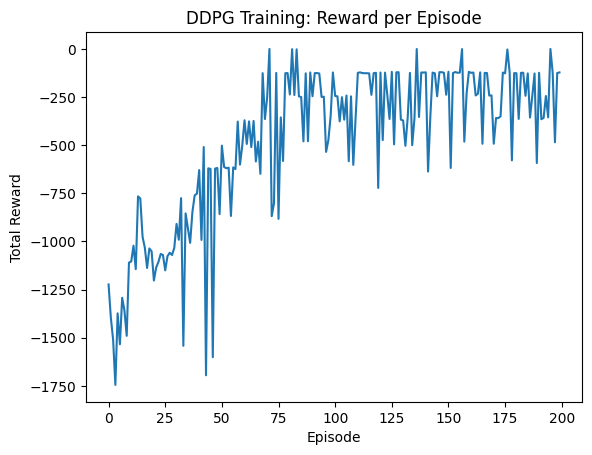

In [13]:
# Main training loop without rendering
for episode in range(num_episodes):
    state = env.reset()  # Reset the environment for each episode
    episode_reward = 0
    done = False

    while not done:
        # Select action using the policy (add noise for exploration)
        action = agent.policy(state)

        # Ensure the action is a scalar (Pendulum expects scalar action)
        action = np.clip(action, env.action_space.low, env.action_space.high)

        # Take action in the environment (without rendering)
        next_state, reward, done, _ = env.step([action])  # Pass action as list

        # Ensure state and next_state are correctly reshaped
        state = np.reshape(state, (state_size,))
        next_state = np.reshape(next_state, (state_size,))

        # Store experience in the replay buffer
        agent.replay_buffer.store(state, action, reward, next_state, done)

        # Update the agent (sample experiences and train)
        agent.train()

        # Update state and accumulate reward
        state = next_state
        episode_reward += reward

    # Store total reward for this episode
    episode_rewards.append(episode_reward)

    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}")

# Plot the reward curve
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DDPG Training: Reward per Episode")
plt.show()


In [15]:
# Save the actor and critic models in Keras format
actor_model.save("ddpg_actor_model.keras")
critic_model.save("ddpg_critic_model.keras")


In [16]:
# Test the trained agent without noise
num_test_episodes = 10
for episode in range(num_test_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # Select action using the trained policy without noise
        action = agent.policy(state)
        action = np.clip(action, env.action_space.low, env.action_space.high)

        # Take action in the environment
        next_state, reward, done, _ = env.step([action])

        # Update state and accumulate reward
        state = next_state
        episode_reward += reward

    print(f"Test Episode {episode + 1}/{num_test_episodes}, Total Reward: {episode_reward}")


Test Episode 1/10, Total Reward: [-233.18239]
Test Episode 2/10, Total Reward: [-125.95068]
Test Episode 3/10, Total Reward: [-245.02379]
Test Episode 4/10, Total Reward: [-599.8194]
Test Episode 5/10, Total Reward: [-368.67355]
Test Episode 6/10, Total Reward: [-124.97035]
Test Episode 7/10, Total Reward: [-241.57462]
Test Episode 8/10, Total Reward: [-122.02011]
Test Episode 9/10, Total Reward: [-240.48283]
Test Episode 10/10, Total Reward: [-357.30594]
